In [1]:
#!pip3 install pandas

import pandas as pd
import zipfile
import os.path

# Define zipped files for processing
# GitHub has 100MB file size limit so had to break them up
directory = 'data'
files = [
    '{}/VCardTransactions-NoName.csv.zip'.format(directory),
    '{}/VCardTransactions-NoName2.csv.zip'.format(directory)
]


# Unzip files if they are not unzipped on local machine
for file in files:
    csvFile = file.replace('.zip','')
    
    if(not os.path.exists(csvFile)):
        print('File DOES NOT exist {} - un-zipping'.format(csvFile))
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(directory)
    else:
        print('File exists {} - NOT un-zipping'.format(csvFile))


# Create combined CSV files

viewFile = '{}/vtrans.csv'.format(directory)
os.makedirs(os.path.dirname(viewFile), exist_ok=True)
if(not os.path.exists(viewFile)):
    print('File NOT exists {} - merging'.format(viewFile))
    with open(files[0].replace('.zip','')) as fp:
        data = fp.read()

    with open(files[1].replace('.zip','')) as fp:
        data2 = fp.read()

    data += "\n"
    data += data2

    with open (viewFile, 'w') as fp:
        fp.write(data)
else:
    print('File exists {} - NOT merging'.format(viewFile))

lotFile = '{}/lot_facts.csv'.format(directory)

File exists data/VCardTransactions-NoName.csv - NOT un-zipping
File exists data/VCardTransactions-NoName2.csv - NOT un-zipping
File exists data/vtrans.csv - NOT merging


In [2]:
# Read in csv file
vtrans = pd.read_csv(viewFile)
vtrans.head()

,tTransID,FullName,CardNumber,LotNumber,EffectiveGroupName,EntranceTime,ExitTime,Sort_Time,BusinessHours,NWHours,UseMoreThan3Hours,HourExceed3Hours,NoEntry,noexit,Consecutive,Overnight
0,22840709,NaN,12777,13,NaN,2022-07-11 12:29:09.493,NaN,2022-07-11 12:29:09.493,NaN,NaN,NaN,NaN,0,1,0,0
1,22840716,NaN,47951,40,NaN,2022-07-11 12:29:09.367,NaN,2022-07-11 12:29:09.367,NaN,NaN,NaN,NaN,0,1,0,0
2,22840719,NaN,58760,3,NaN,2022-07-11 12:29:04.227,NaN,2022-07-11 12:29:04.227,NaN,NaN,NaN,NaN,0,1,0,0
3,22840717,NaN,57369,20,NaN,2022-07-11 12:29:02.680,NaN,2022-07-11 12:29:02.680,NaN,NaN,NaN,NaN,0,1,0,0
4,22840710,NaN,13947,11,NaN,2022-07-11 12:28:53.320,NaN,2022-07-11 12:28:53.320,NaN,NaN,NaN,NaN,0,1,0,0


In [3]:
#!pip3 install numpy
import numpy as np

# Clean vtrans
data = pd.DataFrame()
vtrans['EntranceTime'] = pd.to_datetime(vtrans['EntranceTime'], format='%Y/%m/%d')
vtrans['date'] = vtrans['EntranceTime'].dt.strftime('%Y/%m/%d')
data['date'] = vtrans['date']
data = data.drop_duplicates(subset=["date"])

vtrans.set_index('EntranceTime')
data["date"] = pd.to_datetime(data["date"], format='%Y/%m/%d')
data["y"] = vtrans.groupby('date')['date'].transform('count')


data.head()

,date,y
0,2022-07-11,2594
2594,2022-07-10,1761
4355,2022-07-09,1885
6240,2022-07-08,3620
9860,2022-07-07,3938


In [4]:
data = data.set_index('date')
data = data.sort_index()
data = data.asfreq(freq='D', fill_value=np.nan)

print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0012099213551119178


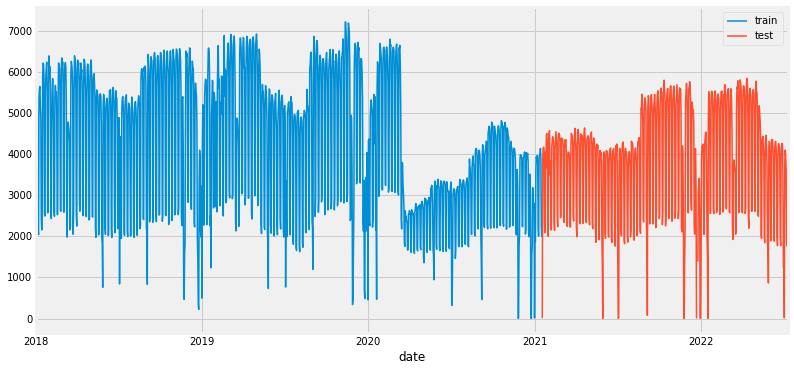

In [5]:
#!pip3 install sklearn
#!pip3 install matplotlib

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Split into 75% training data and 25% testing
steps = 540
data_train = data[:-steps]
data_test  = data[-steps:]

fig, ax=plt.subplots(figsize=(12, 6))
data_train["y"].plot(ax=ax, label='train')
data_test["y"].plot(ax=ax, label='test')
ax.legend();




In [6]:
#!pip3 install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor


forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 180
                )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180] 
Window size: 180 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2018-01-01 00:00:00'), Timestamp('2021-01-17 00:00:

In [7]:
predictions = forecaster.predict(steps=steps)
predictions.head()


2021-01-18    3581.96
2021-01-19    3615.37
2021-01-20    3112.93
2021-01-21    3535.31
2021-01-22    2032.72
Freq: D, Name: pred, dtype: float64

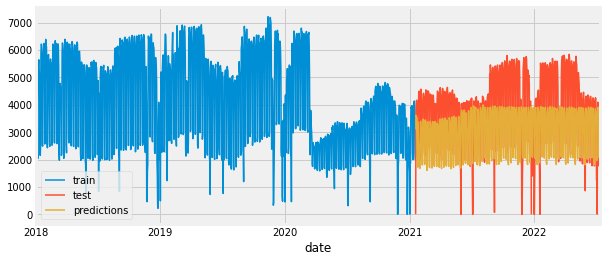

In [8]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train["y"].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();